# Fine Tuning XGBoost Parameters
This kernel will try to introduce you to regression with XGBoost and how to fine-tune its parameters for better results.

The following kernels were a huge help and I took some code snippets from them:
- [Regression to Predict House Prices by Elie Kawerk](https://www.kaggle.com/eliekawerk/regression-to-predict-house-prices)
- [Blending of 6 Models (Top 4%) by Sandeep Kumar](https://www.kaggle.com/sandeepkumar121995/blending-of-6-models-top-10)
- [Regularized Linear Models by Alexandru Papiu](https://www.kaggle.com/apapiu/regularized-linear-models)

In [208]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

#ML
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, train_test_split # Model evaluation
from xgboost import XGBRegressor, DMatrix, plot_importance # XGBoost

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import datetime
import time
import os
#print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [209]:
# Load data and display info dataset
#df_train = pd.read_csv("../input/train.csv", index_col = 0) 
#df_test = pd.read_csv("../input/test.csv", index_col = 0) 

df_train = pd.read_csv("~/datasets/HP-ART//train.csv", index_col = 0) 
df_test = pd.read_csv("~/datasets/HP-ART//test.csv", index_col = 0) 

In [210]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

# Preprocessing

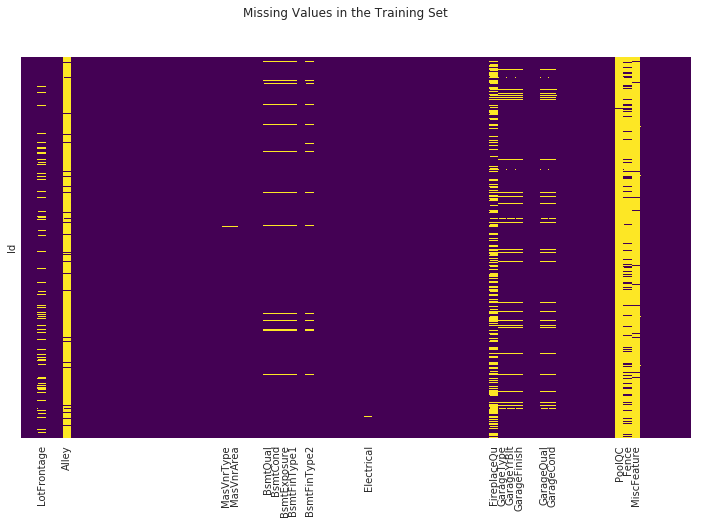

In [211]:
#display Missing values
label_nas = []
for col in df_train.columns.tolist():
    if np.sum(df_train[col].isnull() ) != 0:
        label_nas.append(col)
    else:
        label_nas.append("")

plt.figure(figsize=(12,7))
plt.suptitle('Missing Values in the Training Set')
sns.heatmap(df_train.isnull(), yticklabels=False, xticklabels=label_nas ,cbar = False, cmap='viridis')
plt.show()

In [212]:
#remove columns with too many missed values
null_values_per_col = np.sum(df_train.drop(["SalePrice"], axis=1).isnull(), axis=0)
max_na = int(df_train.shape[0]/3.0) #allowing up to 1/3 of the data to be missing
cols_to_remove = []

for col in df_train.drop(["SalePrice"],axis=1).columns.tolist():
    if null_values_per_col[col] > max_na: 
        cols_to_remove.append(col)
        df_train.drop(col, axis=1, inplace=True)
        
print("New shape of the training set is: (%d,%d)" %df_train.shape)        
print("The removed columns are: " + str(cols_to_remove))

#do the same for test dataset
df_test.drop(cols_to_remove, axis=1, inplace=True)

New shape of the training set is: (1460,75)
The removed columns are: ['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


In [213]:
# MSSubClass is actually categorical even if expressed as numerical
df_train = df_train.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"}})


In [214]:
#remap some columns to have numerical data
rep_map_1 = {"NA": 0, "Po": 1,
             "Fa": 2, "TA": 3, 
             "Gd": 4, "Ex": 5,}

rep_map_2 = {"NA": 0, "No": 1,
             "Mn": 2, "Av": 3, 
             "Gd": 4,}

rep_map_3 = {"NA": 0, "Unf": 1,
             "LwQ": 2, "Rec": 3, 
             "BLQ": 4, "ALQ": 5,
             "GLQ": 6,}

rep_map_4 = {"NA": 0, "MnWw": 1,
             "GdWo": 2, "MnPrv": 3, 
             "GdPrv": 4,}

scale_list_1 = ["ExterCond", "BsmtCond", "HeatingQC", "KitchenQual", "GarageCond"]
scale_list_2 = ["BsmtFinType1"]
scale_list_3 = ["BsmtFinType2"]
scale_list_4 = ["Fence"]

In [215]:
for s in scale_list_1:
    df_train = df_train.replace({s:rep_map_1,})
    df_test = df_test.replace({s:rep_map_1,})

df_train = df_train.replace({scale_list_2[0]:rep_map_2,
                             scale_list_3[0]:rep_map_3,
                             scale_list_4[0]:rep_map_4,})

df_test = df_test.replace({scale_list_2[0]:rep_map_2,
                             scale_list_3[0]:rep_map_3,
                             scale_list_4[0]:rep_map_4,})

In [216]:
#Correlation matrix
corr_mat = df_train.corr().abs()
# Find most important features relative to target
corr_mat.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr_mat.SalePrice)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
KitchenQual      0.659600
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
HeatingQC        0.427649
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
KitchenAbvGr     0.135907
EnclosedPorch    0.128578
GarageCond       0.125013
ScreenPorch      0.111447
PoolArea         0.092404
OverallCond      0.077856
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinType2     0.040139
YrSold           0.028923
LowQualFinSF     0.025606
MiscVal          0.021190
ExterCond   

In [217]:
#Correlation matrix between features
corr_mat = df_train.drop(columns=["SalePrice"]).corr().abs()

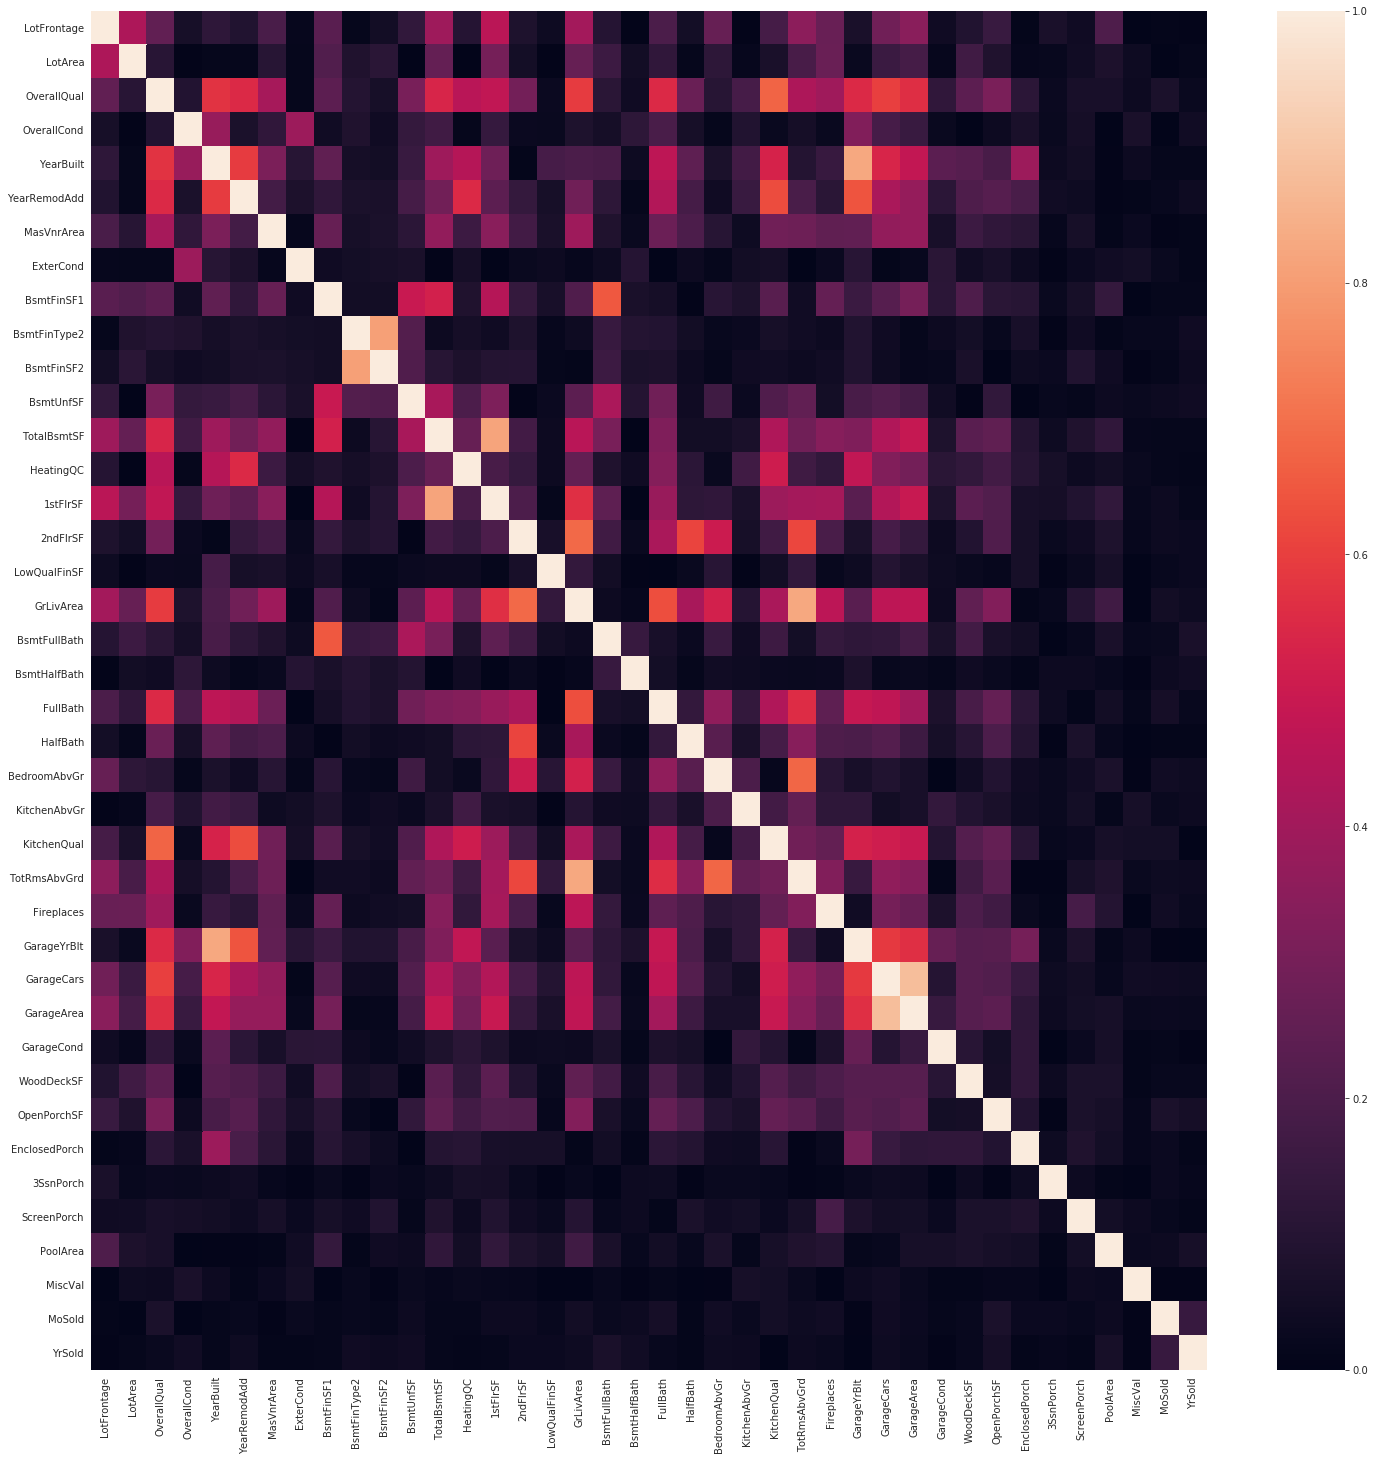

In [218]:
#Plot the heatmap with seaborn
plt.figure(figsize=(25,25)) 
sns.heatmap(corr_mat, 
        xticklabels=corr_mat.columns,
        yticklabels=corr_mat.columns)

In [219]:
#List the highly correlated columns
corr_tmp = corr_mat.unstack()
corr_tmp = corr_tmp.sort_values(kind="quicksort")

print(corr_tmp[-len(corr_mat)-20:-len(corr_mat)])

YearRemodAdd  GarageYrBlt     0.642277
GarageYrBlt   YearRemodAdd    0.642277
BsmtFinSF1    BsmtFullBath    0.649212
BsmtFullBath  BsmtFinSF1      0.649212
OverallQual   KitchenQual     0.673331
KitchenQual   OverallQual     0.673331
BedroomAbvGr  TotRmsAbvGrd    0.676620
TotRmsAbvGrd  BedroomAbvGr    0.676620
GrLivArea     2ndFlrSF        0.687501
2ndFlrSF      GrLivArea       0.687501
BsmtFinSF2    BsmtFinType2    0.805212
BsmtFinType2  BsmtFinSF2      0.805212
TotalBsmtSF   1stFlrSF        0.819530
1stFlrSF      TotalBsmtSF     0.819530
GrLivArea     TotRmsAbvGrd    0.825489
TotRmsAbvGrd  GrLivArea       0.825489
YearBuilt     GarageYrBlt     0.825667
GarageYrBlt   YearBuilt       0.825667
GarageCars    GarageArea      0.882475
GarageArea    GarageCars      0.882475
dtype: float64


In [220]:
#Remove highly correlated columns if needed, I will skip that
rm_corr = False
if rm_corr:
    columns_corr = ["GarageYrBlt", "GarageCars", "GrLivArea"]
    df_train = df_train.drop(columns=columns_corr)
    df_test = df_test.drop(columns=columns_corr)

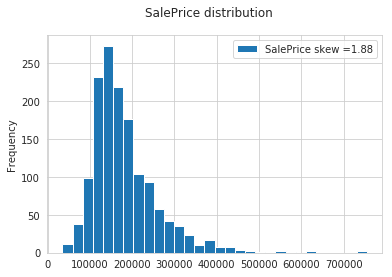

In [221]:
#Check the skewness of SalePrice
skewness = df_train['SalePrice'].skew()
df_train['SalePrice'].plot.hist(edgecolor='white', bins=30, 
                                label='SalePrice skew =' + str(round(skewness,2)))
plt.suptitle("SalePrice distribution")
plt.legend()
plt.show()

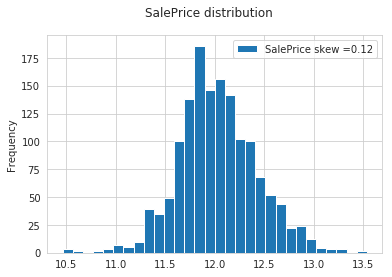

In [222]:
#Apply log1p to reduce skewness
skewness = np.log1p(df_train['SalePrice']).skew()
np.log(df_train['SalePrice']).plot.hist(edgecolor='white', bins=30, 
                                label='SalePrice skew =' + str(round(skewness,2)))
plt.suptitle("SalePrice distribution")
plt.legend()
plt.show()

In [223]:
# Log transform the SalePrice column
df_train['SalePrice'] = np.log1p(df_train['SalePrice'])

In [224]:
#Get a list of all numerical and categorical features
categorical_list = []
numerical_list = []

for col in df_train.drop(columns=["SalePrice"]).columns.tolist():
    if df_train[col].dtype == 'object':
        categorical_list.append(col)
    else:
        numerical_list.append(col)

In [225]:
# Log transform of the skewed numerical features to lessen impact of outliers
skewness = df_train[numerical_list].skew()
skewness = skewness[abs(skewness) > 0.7]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
df_train[skewed_features] = np.log1p(df_train[skewed_features])
df_test[skewed_features] = np.log1p(df_test[skewed_features])

23 skewed numerical features to log transform


In [226]:
#Convert categorical variables into dummy/indicator variables
df_train = pd.get_dummies(df_train, columns=categorical_list)
df_test = pd.get_dummies(df_test, columns=categorical_list)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Columns: 265 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(25), int64(16), uint8(224)
memory usage: 798.4 KB


In [227]:
#If you chose to leave out some columns, remove them now
for col in df_train.columns.tolist():
    if df_train[col].dtype == 'object':
        del df_train[col]
        del df_test[col]
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Columns: 265 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(25), int64(16), uint8(224)
memory usage: 798.4 KB


In [228]:
train_stats = df_train.describe()
train_stats

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterCond,BsmtFinSF1,BsmtFinType2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1422.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,4.207109,9.110966,6.099315,5.575342,1971.267808,1984.865753,2.131946,1.403450,4.229731,0.780863,...,0.003425,0.083562,0.002055,0.867808,0.069178,0.002740,0.008219,0.013699,0.820548,0.085616
std,0.346228,0.517369,1.382997,1.112799,30.202904,20.645407,2.631265,0.083330,2.992052,0.258802,...,0.058440,0.276824,0.045299,0.338815,0.253844,0.052289,0.090317,0.116277,0.383862,0.279893
min,3.091042,7.170888,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.693147,0.000000,0.693147,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.094345,8.929898,5.000000,5.000000,1954.000000,1967.000000,0.000000,1.386294,0.000000,0.693147,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,4.248495,9.156887,6.000000,5.000000,1973.000000,1994.000000,0.000000,1.386294,5.951943,0.693147,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,4.394449,9.358976,7.000000,6.000000,2000.000000,2004.000000,5.117994,1.386294,6.569832,0.693147,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,5.749393,12.279537,10.000000,9.000000,2010.000000,2010.000000,7.378384,1.791759,8.638525,1.945910,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [229]:
#prepare for splitting and normalization
df_train_tmp = df_train.drop(columns=["SalePrice"]) #Normalize across the whole training dataset
norm = False
def norm(x):
    #return (x - train_stats['mean']) / train_stats['std']
    return (x - df_train_tmp.mean()) / (df_train_tmp.max() - df_train_tmp.min())

In [230]:
#Normalise, split Z and Y, split data into 80% training and 20% validation set
y_full = df_train.pop('SalePrice')
if norm:
    X_full = norm(df_train)
    X_test = norm(df_test)
else:
    X_full = df_train
    X_test = df_test

X_train, X_val, y_train, y_val = train_test_split(X_full, y_full, test_size=0.2, random_state=123)

# Parameter Tuning

In [231]:
#Cross validation
kfold = KFold(n_splits=5, shuffle=True, random_state=123)
#Function to quickly recreate the model when needed
def model_eval():
    model = XGBRegressor(learning_rate=0.01, #dflt 0.1
                         verbosity = 3, 
                         objective='reg:linear',
                         n_jobs=-1,
                         subsample=0.7,
                         colsample_bytree=0.35,
                         approx='gpu_hist', #use GPU instead of CPU if available
                         random_state=123)
    return model

In [232]:
# 1: optimise n_estimators and max_depth
# the range to explore depends on the problem, and your observations while trying 
# for the meaning of each parameter, check the official documentation https://xgboost.readthedocs.io/en/latest/parameter.html
n_estimators = range(5000, 7001, 500)
max_depth = range(3,5,1)
# create dictionary with the parameters
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
print("number of combinations: {}".format(len(n_estimators)*len(max_depth)))

number of combinations: 10


In [233]:
#fine tune the model
model = model_eval()
grid_search = GridSearchCV(model, param_grid, scoring="neg_mean_squared_error", n_jobs=-1, cv=kfold, verbose=3)
grid_result = grid_search.fit(X_full, y_full)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  6.1min finished
/home/husmen/miniconda3/envs/tf2/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/husmen/miniconda3/envs/tf2/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [234]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.014151 using {'max_depth': 3, 'n_estimators': 7000}
-0.014167 (0.002054) with: {'max_depth': 3, 'n_estimators': 5000}
-0.014155 (0.002056) with: {'max_depth': 3, 'n_estimators': 5500}
-0.014157 (0.002044) with: {'max_depth': 3, 'n_estimators': 6000}
-0.014155 (0.002031) with: {'max_depth': 3, 'n_estimators': 6500}
-0.014151 (0.002020) with: {'max_depth': 3, 'n_estimators': 7000}
-0.014257 (0.002092) with: {'max_depth': 4, 'n_estimators': 5000}
-0.014255 (0.002096) with: {'max_depth': 4, 'n_estimators': 5500}
-0.014261 (0.002091) with: {'max_depth': 4, 'n_estimators': 6000}
-0.014255 (0.002089) with: {'max_depth': 4, 'n_estimators': 6500}
-0.014259 (0.002091) with: {'max_depth': 4, 'n_estimators': 7000}


Text(0, 0.5, 'MSE')

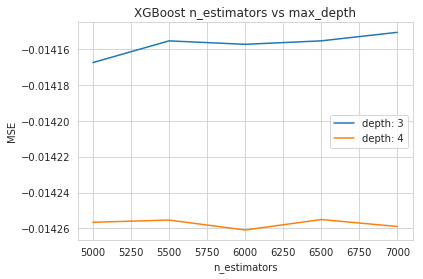

In [235]:
# plot results
scores = np.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
    plt.plot(n_estimators, scores[i], label='depth: ' + str(value))
plt.legend()
plt.title("XGBoost n_estimators vs max_depth")
plt.xlabel('n_estimators')
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

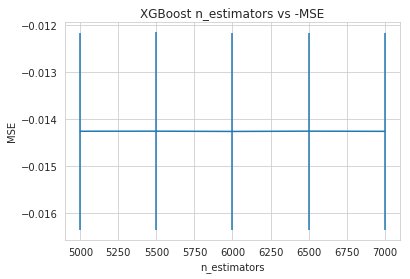

In [236]:
#plot n_estimators with its standard deviation
scores_1 = np.array(means).reshape(len(max_depth), len(n_estimators))
scores_2 = np.array(stds).reshape(len(max_depth), len(n_estimators))

plt.errorbar(n_estimators, scores_1[1], yerr=scores_2[1])
plt.title("XGBoost n_estimators vs -MSE")
plt.xlabel('n_estimators')
plt.ylabel('MSE')

In [238]:
# 2: add min_child_weight parameter
# we could have done this from the beginning, but I wanted to show some graphs above first
n_estimators = [7000]
max_depth = [3]
min_child_weight = range(2, 5, 1)
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators, min_child_weight=min_child_weight)
print("number of combinations: {}".format(len(n_estimators)*len(max_depth)*len(min_child_weight)))

number of combinations: 3


In [239]:
model = model_eval()
grid_search = GridSearchCV(model, param_grid, scoring="neg_mean_squared_error", n_jobs=-1, cv=kfold, verbose=3)
grid_result = grid_search.fit(X_full, y_full)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:   38.4s remaining:   57.6s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  2.5min remaining:   38.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.6min finished


In [240]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.014145 using {'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 7000}
-0.014204 (0.001672) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 7000}
-0.014145 (0.001692) with: {'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 7000}
-0.014415 (0.001782) with: {'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 7000}


In [241]:
# 3: add gamma, reg_alpha and reg_lambda, 
n_estimators = [7000]
max_depth = [3]
min_child_weight = [3]
gamma = np.arange(0, 0.00001, 0.00002) # only 0 on purpose, 
reg_alpha = np.arange(0.00000, 0.0001, 0.00003)
reg_lambda= np.arange(1, 0.9999, -0.00003)

param_grid = dict(n_estimators = n_estimators, max_depth = max_depth, min_child_weight = min_child_weight,
                  gamma = gamma, reg_alpha=reg_alpha, reg_lambda=reg_lambda)
print("number of combinations: {}".format(len(gamma)*len(reg_alpha)*len(reg_lambda)))

number of combinations: 16


In [242]:
model = model_eval()
grid_search = GridSearchCV(model, param_grid, scoring="neg_mean_squared_error", n_jobs=-1, cv=kfold, verbose=3)
grid_result = grid_search.fit(X_full, y_full)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  9.2min finished


In [243]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.014131 using {'gamma': 0.0, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 7000, 'reg_alpha': 3e-05, 'reg_lambda': 0.99994}
-0.014145 (0.001692) with: {'gamma': 0.0, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 7000, 'reg_alpha': 0.0, 'reg_lambda': 1.0}
-0.014171 (0.001700) with: {'gamma': 0.0, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 7000, 'reg_alpha': 0.0, 'reg_lambda': 0.99997}
-0.014149 (0.001694) with: {'gamma': 0.0, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 7000, 'reg_alpha': 0.0, 'reg_lambda': 0.99994}
-0.014174 (0.001715) with: {'gamma': 0.0, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 7000, 'reg_alpha': 0.0, 'reg_lambda': 0.9999100000000001}
-0.014160 (0.001684) with: {'gamma': 0.0, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 7000, 'reg_alpha': 3e-05, 'reg_lambda': 1.0}
-0.014156 (0.001693) with: {'gamma': 0.0, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 7000, 'reg_alpha': 3e-05, 'reg_lambda

# Training

In [260]:
# final model with tuned parameters
model = XGBRegressor(max_depth=4, #dflt 6
                     learning_rate=0.01, #dflt 100
                     n_estimators=6000, #dflt 0.1
                     verbosity = 3,
                     objective='reg:linear',
                     n_jobs=-1,
                     gamma=0, #dflt: 0
                     min_child_weight=3, #0 dflt: 1
                     subsample=0.7,
                     colsample_bytree=0.35,
                     reg_lambda=0.99994, #dflt: 1
                     reg_alpha=0.00003, #dflt: 0
                     tree_method='exact',
                     scale_pos_weight=1, # dflt: 1
                     random_state=123)

In [261]:
# final Cross-Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=123)
results = cross_val_score(model, X_full, y_full, scoring="neg_mean_squared_error", n_jobs=-1, cv=kfold, verbose=3)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   25.6s remaining:   38.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   33.4s finished


In [262]:
# CV results
results_rmsle = np.sqrt(-results)
print("-MSE: {} ({})".format(results.mean(),results.std()))
print("RMS(L)E: {} ({})".format(results_rmsle.mean(),results_rmsle.std()))

-MSE: -0.0141256212633117 (0.001573236240601648)
RMS(L)E: 0.118660486798392 (0.006731280419083266)


In [263]:
#Final training
tick=time.time()

fitted_model = model.fit(X_train, y_train,
                         eval_set=[(X_val, y_val)],
                         eval_metric='rmse', # Equivalent to RMSLE since we have log1p(SalePrice)
                         early_stopping_rounds=200,
                         verbose=True)

print("Duration: {}s".format(time.time()-tick))

[0]	validation_0-rmse:11.4245
Will train until validation_0-rmse hasn't improved in 200 rounds.
[1]	validation_0-rmse:11.3105
[2]	validation_0-rmse:11.1979
[3]	validation_0-rmse:11.0862
[4]	validation_0-rmse:10.9756
[5]	validation_0-rmse:10.8663
[6]	validation_0-rmse:10.758
[7]	validation_0-rmse:10.6508
[8]	validation_0-rmse:10.5446
[9]	validation_0-rmse:10.4396
[10]	validation_0-rmse:10.3355
[11]	validation_0-rmse:10.2327
[12]	validation_0-rmse:10.1306
[13]	validation_0-rmse:10.0297
[14]	validation_0-rmse:9.92986
[15]	validation_0-rmse:9.8309
[16]	validation_0-rmse:9.73306
[17]	validation_0-rmse:9.63619
[18]	validation_0-rmse:9.54016
[19]	validation_0-rmse:9.44504
[20]	validation_0-rmse:9.35104
[21]	validation_0-rmse:9.25782
[22]	validation_0-rmse:9.16575
[23]	validation_0-rmse:9.07455
[24]	validation_0-rmse:8.98426
[25]	validation_0-rmse:8.89484
[26]	validation_0-rmse:8.80621
[27]	validation_0-rmse:8.71861
[28]	validation_0-rmse:8.63174
[29]	validation_0-rmse:8.54572
[30]	validation_

[258]	validation_0-rmse:0.889445
[259]	validation_0-rmse:0.880976
[260]	validation_0-rmse:0.872562
[261]	validation_0-rmse:0.864231
[262]	validation_0-rmse:0.855957
[263]	validation_0-rmse:0.847803
[264]	validation_0-rmse:0.839646
[265]	validation_0-rmse:0.831721
[266]	validation_0-rmse:0.823815
[267]	validation_0-rmse:0.815863
[268]	validation_0-rmse:0.808187
[269]	validation_0-rmse:0.800534
[270]	validation_0-rmse:0.792876
[271]	validation_0-rmse:0.785216
[272]	validation_0-rmse:0.777844
[273]	validation_0-rmse:0.770569
[274]	validation_0-rmse:0.763358
[275]	validation_0-rmse:0.756297
[276]	validation_0-rmse:0.749229
[277]	validation_0-rmse:0.742224
[278]	validation_0-rmse:0.735298
[279]	validation_0-rmse:0.728301
[280]	validation_0-rmse:0.721458
[281]	validation_0-rmse:0.714717
[282]	validation_0-rmse:0.707969
[283]	validation_0-rmse:0.70146
[284]	validation_0-rmse:0.694906
[285]	validation_0-rmse:0.688406
[286]	validation_0-rmse:0.681983
[287]	validation_0-rmse:0.675704
[288]	valid

[508]	validation_0-rmse:0.147871
[509]	validation_0-rmse:0.147428
[510]	validation_0-rmse:0.146951
[511]	validation_0-rmse:0.146523
[512]	validation_0-rmse:0.1461
[513]	validation_0-rmse:0.145657
[514]	validation_0-rmse:0.145209
[515]	validation_0-rmse:0.144791
[516]	validation_0-rmse:0.144362
[517]	validation_0-rmse:0.144034
[518]	validation_0-rmse:0.143636
[519]	validation_0-rmse:0.143226
[520]	validation_0-rmse:0.14281
[521]	validation_0-rmse:0.142431
[522]	validation_0-rmse:0.142026
[523]	validation_0-rmse:0.141673
[524]	validation_0-rmse:0.141287
[525]	validation_0-rmse:0.140954
[526]	validation_0-rmse:0.140569
[527]	validation_0-rmse:0.140185
[528]	validation_0-rmse:0.139812
[529]	validation_0-rmse:0.139507
[530]	validation_0-rmse:0.139143
[531]	validation_0-rmse:0.138772
[532]	validation_0-rmse:0.138444
[533]	validation_0-rmse:0.138097
[534]	validation_0-rmse:0.137802
[535]	validation_0-rmse:0.137515
[536]	validation_0-rmse:0.137183
[537]	validation_0-rmse:0.136911
[538]	validat

[758]	validation_0-rmse:0.114415
[759]	validation_0-rmse:0.114394
[760]	validation_0-rmse:0.114405
[761]	validation_0-rmse:0.114389
[762]	validation_0-rmse:0.114366
[763]	validation_0-rmse:0.11434
[764]	validation_0-rmse:0.114277
[765]	validation_0-rmse:0.114239
[766]	validation_0-rmse:0.114194
[767]	validation_0-rmse:0.114144
[768]	validation_0-rmse:0.114141
[769]	validation_0-rmse:0.114084
[770]	validation_0-rmse:0.114058
[771]	validation_0-rmse:0.114036
[772]	validation_0-rmse:0.114043
[773]	validation_0-rmse:0.114033
[774]	validation_0-rmse:0.11401
[775]	validation_0-rmse:0.113978
[776]	validation_0-rmse:0.113946
[777]	validation_0-rmse:0.113921
[778]	validation_0-rmse:0.113893
[779]	validation_0-rmse:0.113859
[780]	validation_0-rmse:0.113847
[781]	validation_0-rmse:0.113843
[782]	validation_0-rmse:0.113814
[783]	validation_0-rmse:0.113787
[784]	validation_0-rmse:0.113722
[785]	validation_0-rmse:0.113725
[786]	validation_0-rmse:0.113705
[787]	validation_0-rmse:0.11366
[788]	validat

[1007]	validation_0-rmse:0.109969
[1008]	validation_0-rmse:0.109948
[1009]	validation_0-rmse:0.109951
[1010]	validation_0-rmse:0.109936
[1011]	validation_0-rmse:0.109944
[1012]	validation_0-rmse:0.109944
[1013]	validation_0-rmse:0.10992
[1014]	validation_0-rmse:0.109916
[1015]	validation_0-rmse:0.109916
[1016]	validation_0-rmse:0.109902
[1017]	validation_0-rmse:0.109894
[1018]	validation_0-rmse:0.109885
[1019]	validation_0-rmse:0.109855
[1020]	validation_0-rmse:0.109864
[1021]	validation_0-rmse:0.109853
[1022]	validation_0-rmse:0.109846
[1023]	validation_0-rmse:0.109848
[1024]	validation_0-rmse:0.109829
[1025]	validation_0-rmse:0.109828
[1026]	validation_0-rmse:0.109844
[1027]	validation_0-rmse:0.109803
[1028]	validation_0-rmse:0.109815
[1029]	validation_0-rmse:0.10981
[1030]	validation_0-rmse:0.109799
[1031]	validation_0-rmse:0.109772
[1032]	validation_0-rmse:0.109763
[1033]	validation_0-rmse:0.109753
[1034]	validation_0-rmse:0.109753
[1035]	validation_0-rmse:0.10973
[1036]	validation

[1249]	validation_0-rmse:0.10844
[1250]	validation_0-rmse:0.108446
[1251]	validation_0-rmse:0.108441
[1252]	validation_0-rmse:0.108442
[1253]	validation_0-rmse:0.108438
[1254]	validation_0-rmse:0.108448
[1255]	validation_0-rmse:0.108437
[1256]	validation_0-rmse:0.108431
[1257]	validation_0-rmse:0.108436
[1258]	validation_0-rmse:0.108423
[1259]	validation_0-rmse:0.108413
[1260]	validation_0-rmse:0.108419
[1261]	validation_0-rmse:0.108403
[1262]	validation_0-rmse:0.108409
[1263]	validation_0-rmse:0.108393
[1264]	validation_0-rmse:0.108382
[1265]	validation_0-rmse:0.108373
[1266]	validation_0-rmse:0.108385
[1267]	validation_0-rmse:0.10835
[1268]	validation_0-rmse:0.108361
[1269]	validation_0-rmse:0.108363
[1270]	validation_0-rmse:0.10836
[1271]	validation_0-rmse:0.108356
[1272]	validation_0-rmse:0.108356
[1273]	validation_0-rmse:0.108345
[1274]	validation_0-rmse:0.10838
[1275]	validation_0-rmse:0.10837
[1276]	validation_0-rmse:0.108348
[1277]	validation_0-rmse:0.108355
[1278]	validation_0

[1491]	validation_0-rmse:0.107776
[1492]	validation_0-rmse:0.107755
[1493]	validation_0-rmse:0.107749
[1494]	validation_0-rmse:0.107748
[1495]	validation_0-rmse:0.107761
[1496]	validation_0-rmse:0.107744
[1497]	validation_0-rmse:0.107745
[1498]	validation_0-rmse:0.107744
[1499]	validation_0-rmse:0.10774
[1500]	validation_0-rmse:0.107751
[1501]	validation_0-rmse:0.107759
[1502]	validation_0-rmse:0.107763
[1503]	validation_0-rmse:0.107756
[1504]	validation_0-rmse:0.10773
[1505]	validation_0-rmse:0.107727
[1506]	validation_0-rmse:0.107718
[1507]	validation_0-rmse:0.107691
[1508]	validation_0-rmse:0.107706
[1509]	validation_0-rmse:0.107696
[1510]	validation_0-rmse:0.107678
[1511]	validation_0-rmse:0.107665
[1512]	validation_0-rmse:0.107653
[1513]	validation_0-rmse:0.107637
[1514]	validation_0-rmse:0.10764
[1515]	validation_0-rmse:0.107634
[1516]	validation_0-rmse:0.107642
[1517]	validation_0-rmse:0.107659
[1518]	validation_0-rmse:0.107659
[1519]	validation_0-rmse:0.107667
[1520]	validation

[1733]	validation_0-rmse:0.107244
[1734]	validation_0-rmse:0.107253
[1735]	validation_0-rmse:0.107251
[1736]	validation_0-rmse:0.107246
[1737]	validation_0-rmse:0.107248
[1738]	validation_0-rmse:0.107268
[1739]	validation_0-rmse:0.107261
[1740]	validation_0-rmse:0.107262
[1741]	validation_0-rmse:0.107265
[1742]	validation_0-rmse:0.107271
[1743]	validation_0-rmse:0.107272
[1744]	validation_0-rmse:0.107294
[1745]	validation_0-rmse:0.107297
[1746]	validation_0-rmse:0.10733
[1747]	validation_0-rmse:0.107325
[1748]	validation_0-rmse:0.107334
[1749]	validation_0-rmse:0.107326
[1750]	validation_0-rmse:0.107319
[1751]	validation_0-rmse:0.107312
[1752]	validation_0-rmse:0.107312
[1753]	validation_0-rmse:0.107306
[1754]	validation_0-rmse:0.107309
[1755]	validation_0-rmse:0.107316
[1756]	validation_0-rmse:0.107317
[1757]	validation_0-rmse:0.107294
[1758]	validation_0-rmse:0.107288
[1759]	validation_0-rmse:0.107282
[1760]	validation_0-rmse:0.107285
[1761]	validation_0-rmse:0.10729
[1762]	validatio

[1975]	validation_0-rmse:0.107325
[1976]	validation_0-rmse:0.107332
[1977]	validation_0-rmse:0.107331
[1978]	validation_0-rmse:0.107324
[1979]	validation_0-rmse:0.107336
[1980]	validation_0-rmse:0.107334
Stopping. Best iteration:
[1780]	validation_0-rmse:0.107236

Duration: 10.850090742111206s


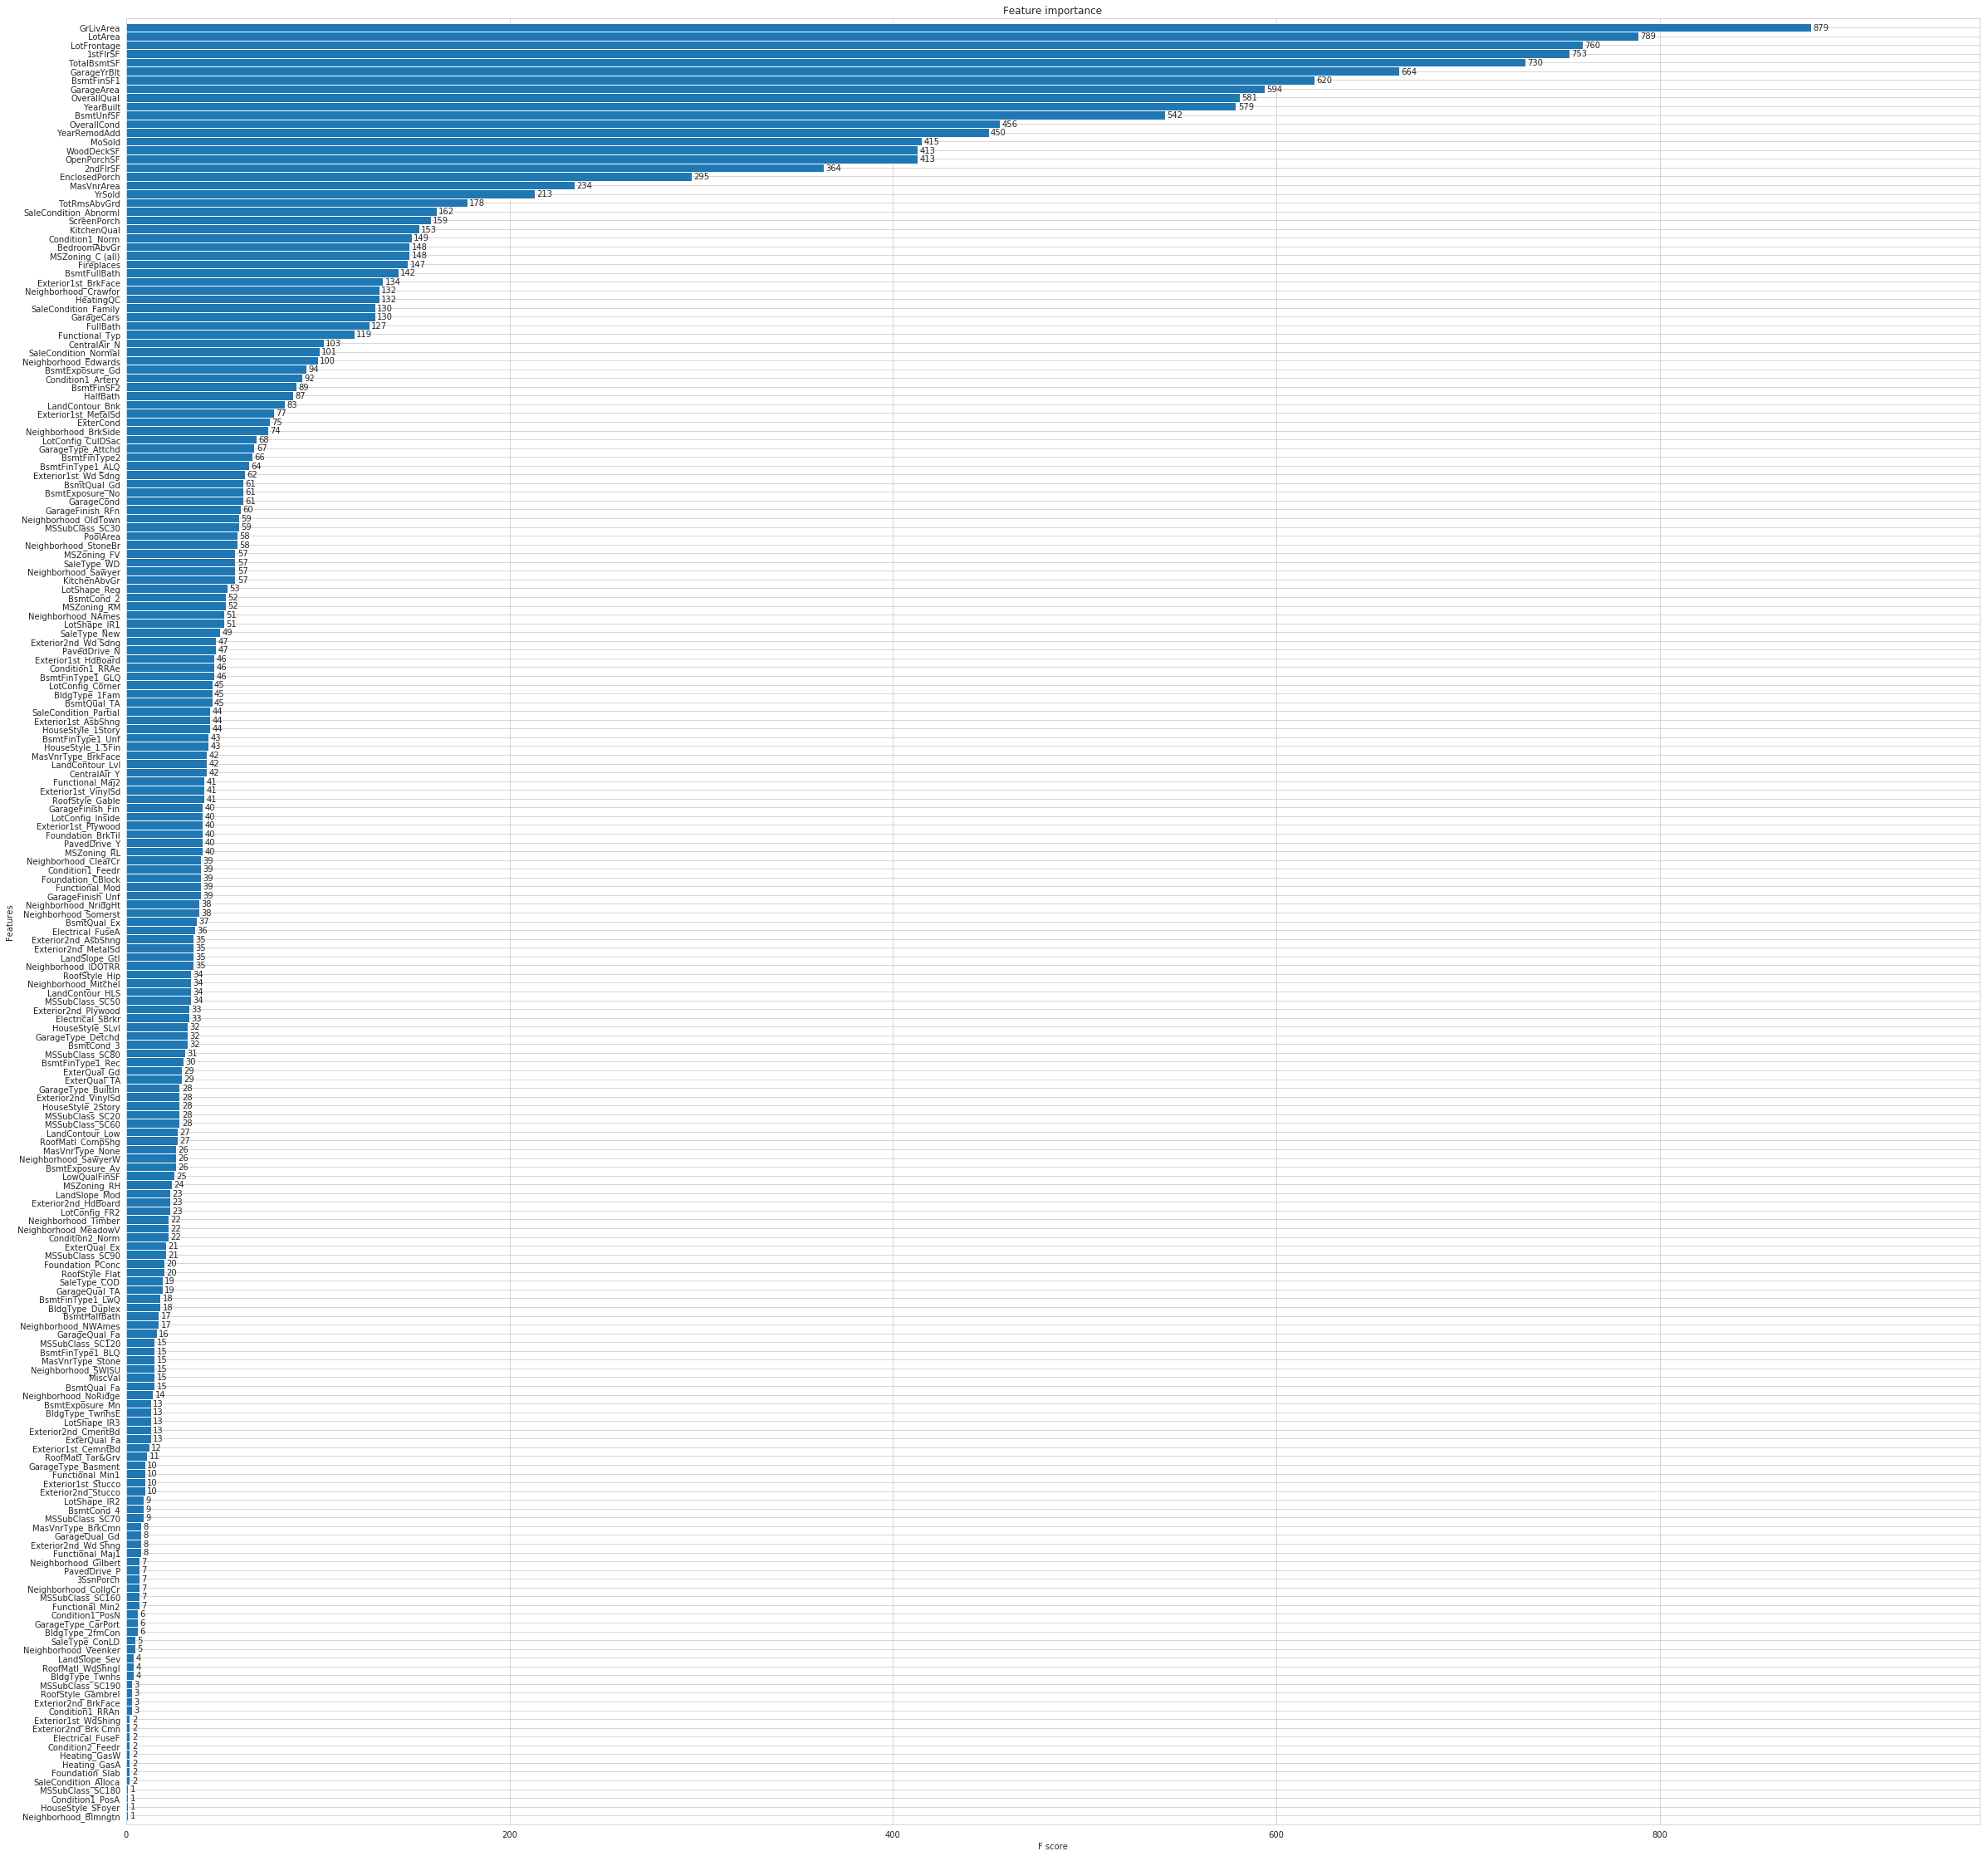

In [248]:
# Plot feature importance
figsize=(40,40)
fig, ax = plt.subplots(1,1,figsize=figsize)
plot_importance(model, ax=ax,height = 1)

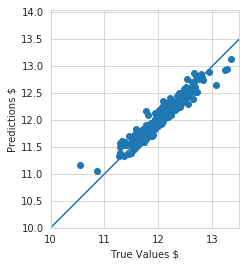

In [264]:
# predict sales in validation dataset
val_predictions = model.predict(X_val).flatten()

# scatter plot of True vs Predicted values
plt.scatter(y_val, val_predictions)
plt.xlabel('True Values $')
plt.ylabel('Predictions $')
plt.axis('equal')
plt.axis('square')
plt.xlim([10,plt.xlim()[1]])
plt.ylim([10,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

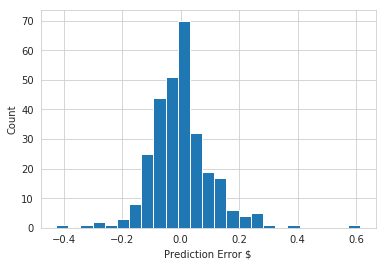

In [265]:
# Histogram of error values
error = val_predictions - y_val
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error $")
_ = plt.ylabel("Count")

# Submission

In [251]:
# predict sales for test dataset
predictions = model.predict(X_test[X_train.columns]) # keep columns in same order
# reverse log1p, and round results
predictions = np.round(np.exp(predictions)-1)
print(predictions)

[125163. 163208. 180490. ... 168143. 116067. 224924.]


In [252]:
# prepare dataframe to submit
submission = pd.DataFrame({'Id': df_test.index, 'SalePrice': predictions})
submission.head()

,Id,SalePrice
0,1461,125163.0
1,1462,163208.0
2,1463,180490.0
3,1464,192129.0
4,1465,187621.0


In [253]:
# submit
t_stamp = str(datetime.datetime.now())
t1 = t_stamp.split(" ")[0]
t2 = t_stamp.split(" ")[1].split(".")[0]
submission.to_csv('lgbm2_{}_{}_{}.csv'.format(t1, t2, round(results_rmsle.mean(),5)), index=False)